# Brain Tumor  Semantic Highlighting

---
## Imports

Imports all packages used in this project.

In [1]:
import torch
import os
from pathlib import Path
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
from torchvision.transforms import v2
import pandas as pd
from itertools import chain
from PIL import Image
from torch.utils.data import Dataset
import torch.nn.functional as F
import h5py
import numpy as np
from matplotlib.colors import ListedColormap
import re, random
from collections import defaultdict
from typing import Callable, Optional, Sequence, Dict, Any, List, Tuple
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

---
## 1. Loading the data and preprocessing

Visually inspect images:

In [2]:
def _robust_norm(x, p_lo=0.5, p_hi=99.5):
    """Perform robust normalization using percentile clipping."""
    lo, hi = np.percentile(x, [p_lo, p_hi])
    x = np.clip(x, lo, hi)
    if hi > lo:
        x = (x - lo) / (hi - lo)
    else:
        x = np.zeros_like(x)
    return x

def _as_onehot3(mask):
    """
    Convert a (H, W) integer mask into a 3-channel one-hot mask (H, W, 3).
    Expected label values:
        1: Necrosis / Non-enhancing tumor
        2: Edema
        4: Enhancing tumor
    If none of these labels are present, returns all-zeros.
    """
    if mask.ndim == 3 and mask.shape[-1] == 3:
        return mask.astype(np.float32)
    oh = np.zeros(mask.shape + (3,), dtype=np.float32)
    oh[..., 0] = (mask == 1).astype(np.float32)
    oh[..., 1] = (mask == 2).astype(np.float32)
    oh[..., 2] = (mask == 4).astype(np.float32)
    return oh

def overlay_replace_on_flair(
    image,                       # (H,W,4) float
    mask,                        # (H,W,3) one-hot/prob OR (H,W) labels
    flair_idx=3,                 # index of FLAIR channel
    mask_colors=((1,0,0),(1,1,0),(0,1,0)),   # R/G/B for [Necrosis, Edema, Enhancing]
    thresh=0.5,                  # binarization threshold for prob masks
    conflict_mode="priority",    # "priority" or "argmax"
    alpha=None,                  # None to hard replace; float in (0,1) for alpha blend
    priority=(2,1,0),            # only used when conflict_mode="priority" (index in [0,1,2])
    show=True
):
    """
    Convert FLAIR to RGB and replace pixels under mask with class colors.
    If alpha is not None, do per-pixel blending instead of hard replacement.
    """
    H, W, C = image.shape
    assert C > flair_idx, "flair_idx out of range"
    base = _robust_norm(image[..., flair_idx])               # (H,W) in [0,1]
    base_rgb = np.repeat(base[..., None], 3, axis=2)        # (H,W,3)

    m = _as_onehot3(mask)                                    # (H,W,3)
    # binarize to avoid interpolation leakage
    m_bin = (m > thresh).astype(np.uint8)                   # (H,W,3)

    if conflict_mode == "argmax":
        # choose the channel with highest prob; mask out background
        cls_idx = np.argmax(m, axis=-1)                     # (H,W)
        fg = (m.max(axis=-1) > thresh)                      # (H,W) boolean
        # build a 3D boolean index per class
        for i, color in enumerate(mask_colors):
            sel = (cls_idx == i) & fg
            if np.any(sel):
                if alpha is None:
                    base_rgb[sel, :] = color
                else:
                    base_rgb[sel, :] = (1 - alpha) * base_rgb[sel, :] + alpha * np.array(color)
    elif conflict_mode == "priority":
        # apply in given order; later classes overwrite earlier ones
        for i in priority:
            sel = m_bin[..., i].astype(bool)
            if np.any(sel):
                if alpha is None:
                    base_rgb[sel, :] = mask_colors[i]
                else:
                    base_rgb[sel, :] = (1 - alpha) * base_rgb[sel, :] + alpha * np.array(mask_colors[i])
    else:
        raise ValueError("conflict_mode must be 'priority' or 'argmax'")

    if show:
        plt.figure(figsize=(6,6))
        plt.imshow(base_rgb, interpolation="nearest")
        plt.title("Mask replaced on FLAIR (RGB)")
        plt.axis("off")
        plt.show()

    return base_rgb

def display_image(
    file_path: str,
    modality_names=("T1","T1Gd","T2","FLAIR"),
    mask_names=("Necrosis","Edema","Enhancing"),
    overlay_modality: str | None = "FLAIR",
    overlay_alpha: float = 0.35,
    show_contour: bool = True,
    # per-channel colors (RGB tuples or hex). Order must match mask_names / channels
    mask_colors=((0.0, 1.0, 0.0),  # Necrosis -> green
                 (1.0, 0.0, 1.0),  # Edema    -> magenta
                 (1.0, 0.0, 0.0)), # Enhancing-> red
):
    """
    Visualize a single .h5 BraTS slice file containing:
        - image: (H, W, 4) multimodal MRI data
        - mask : (H, W, 3) or (H, W) segmentation mask

    Parameters
    ----------
    file_path : str
        Path to the .h5 file.
    modality_names : tuple of str
        Names of the 4 MRI modalities, in order.
    mask_names : tuple of str
        Names of the 3 segmentation channels.
    overlay_modality : str | None
        Which modality to overlay the mask on (default: "FLAIR").
        Set to None to disable overlay.
    overlay_alpha : float
        Transparency for mask overlay (0–1).
    show_contour : bool
        If True, draw contour lines around mask regions.
    """
    # --- Load data ---
    with h5py.File(file_path, "r") as f:
        image = f["image"][:]  # (H, W, 4)
        mask  = f["mask"][:]   # (H, W, 3) or (H, W)
        # print the shape
        print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
        # print mask unique values
        print(f"Mask unique values: {np.unique(mask)}")
        

    # --- Convert mask safely to one-hot format ---
    if mask.ndim == 2 or (mask.ndim == 3 and mask.shape[-1] == 1):
        mask = _as_onehot3(mask.squeeze())
    elif mask.ndim == 3 and mask.shape[-1] == 3:
        mask = mask.astype(np.float32)
    else:
        raise ValueError(f"Unexpected mask shape: {mask.shape}, expected (H,W,3) or (H,W).")

    # --- Display each modality ---
    H, W, C = image.shape
    if C != 4:
        raise ValueError(f"Expected 4 channels, got {image.shape}")

    for i in range(4):
        plt.figure(figsize=(4.5, 4.5))
        plt.imshow(_robust_norm(image[..., i]), cmap="gray")
        plt.title(modality_names[i] if i < len(modality_names) else f"Modality {i}")
        plt.axis("off")
        plt.show()
    
    '''
    # --- Display each mask channel with its own color ---
    for i in range(3):
        m = mask[..., i]
        plt.figure(figsize=(4.5, 4.5))
        # build a 2-color discrete cmap: background transparent-ish, foreground = mask_colors[i]
        fg = mask_colors[i]
        cmap = ListedColormap([(0,0,0,0), (*fg, 1.0)])  # RGBA
        plt.imshow(m, cmap=cmap, interpolation="nearest")
        plt.title(mask_names[i] if i < len(mask_names) else f"Mask {i}")
        plt.axis("off")
        plt.show()
    '''

    # --- Overlay each mask channel using its dedicated color ---
    rgb = overlay_replace_on_flair(
        image, mask,
        flair_idx=3,
        mask_colors=mask_colors,
        thresh=0.5,
        conflict_mode="priority",               # or "argmax"
        alpha=None,                             # None=hard replace；0.35=blend
        priority=(2,1,0)                        # Enhancing > Edema > Necrosis
    )
        
    '''
    # Optional: combined label map (0=bg, 1/2/3 = channels)
    combined = np.zeros(mask.shape[:2], dtype=int)
    for i in range(3):
        combined[mask[..., i] > 0.5] = i + 1

    combo_cmap = ListedColormap([
        (0,0,0,0),                    # 0 background transparent
        (*mask_colors[0], 1.0),       # 1
        (*mask_colors[1], 1.0),       # 2
        (*mask_colors[2], 1.0),       # 3
    ])
    plt.figure(figsize=(5,5))
    plt.imshow(combined, cmap=combo_cmap, interpolation="nearest")
    plt.title("Combined Mask")
    plt.axis("off")
    plt.show()
    '''

Image shape: (240, 240, 4), Mask shape: (240, 240, 3)
Mask unique values: [0 1]


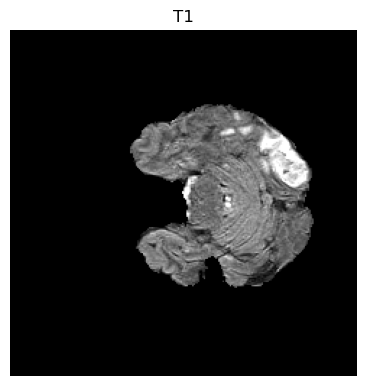

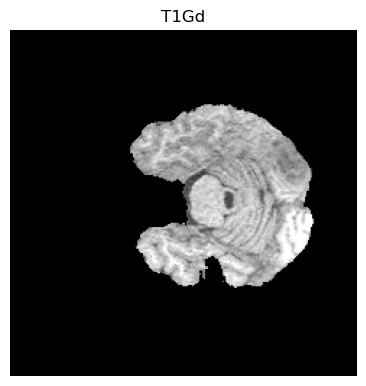

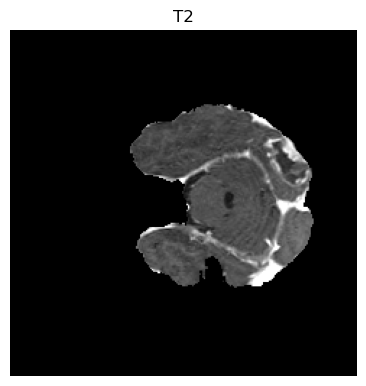

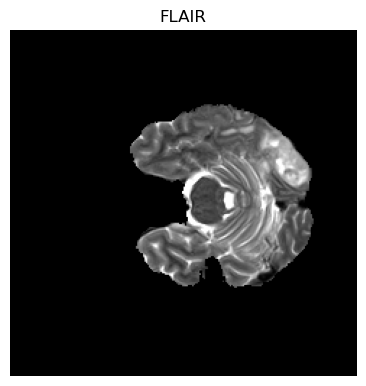

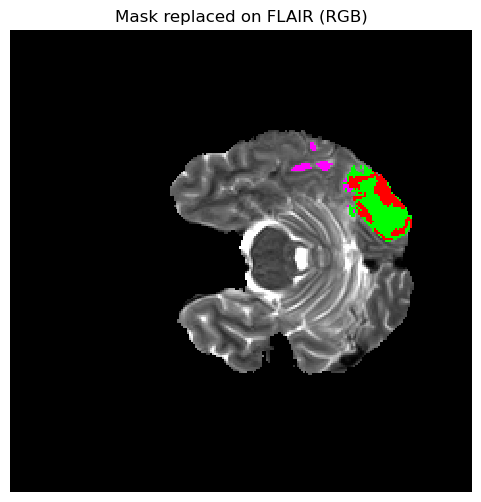

In [3]:
image_path = "./brats2020-training-data/BraTS2020_training_data/content/data/volume_41_slice_35.h5"
display_image(
    image_path,
    modality_names=("T1", "T1Gd", "T2", "FLAIR"),
    mask_names=("Necrosis-1", "Edema-2", "Enhancing-4"),
    overlay_modality="FLAIR",
    overlay_alpha=0.35,
    show_contour=True
)
